## **Exploratory Data Analysis**

### Task: Import libraries and external modules

In [1]:
import sys, gc
from pathlib import Path
from polars.selectors import numeric
import matplotlib.pyplot as plt, seaborn as sns, polars as pl, numpy as np

sys.path.insert(0, str(Path("../utilities").resolve()))
from logger import Logger
from configurations import Configurations

sns.set_style("whitegrid")


### Task: Configurations

In [2]:
logger = Logger("exploratory_data_analysis", Configurations.LOG_PATH)
PROCESSED_DIR = Path(Configurations.DATA_PROCESSED_PATH)
VALID_CORES, VALID_CATEGORIES, VALID_SPLITS, VALID_COLS = Configurations.CORES, Configurations.CATEGORIES, Configurations.SPLITS_EDA, Configurations.COLUMNS

for k, v in {"VALID_CORES": VALID_CORES, "VALID_CATEGORIES": VALID_CATEGORIES, "VALID_SPLITS": VALID_SPLITS, "VALID_COLS": VALID_COLS}.items():
    logger.log_info(f"{k} = {v}")

2025-10-10 21:54:25,585 - INFO - VALID_CORES = ['5core']
2025-10-10 21:54:25,585 - INFO - VALID_CATEGORIES = ['Electronics', 'Beauty_and_Personal_Care', 'Sports_and_Outdoors']
2025-10-10 21:54:25,586 - INFO - VALID_SPLITS = ['train']
2025-10-10 21:54:25,586 - INFO - VALID_COLS = ['user_id', 'parent_asin', 'rating', 'timestamp']


### Task: Grouped EDA functions with interpretation

#### Load_helpers

In [3]:
def _file_path(core: str, category: str, split: str) -> Path:
    dev_sample_size = Configurations.DEV_SAMPLE_SIZE

    if dev_sample_size != 'full':
        sample_sizes = Configurations.SAMPLE_SIZES
        for size_name in sample_sizes.keys():
            if size_name == dev_sample_size:
             return PROCESSED_DIR / f"{category.replace('/', '-')}.{core}.{split}.{size_name}.parquet"
    else:
        return PROCESSED_DIR / f"{category.replace('/', '-')}.{core}.{split}.parquet"
       

def _read_split_file(path: Path, split: str, downcast: bool = False) -> pl.DataFrame:
    df = pl.read_parquet(path, columns=VALID_COLS)
    missing = [c for c in VALID_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns {missing} in {path.name}")
    if downcast:
        cols = []
        if "rating" in df.columns:
            cols.append(pl.col("rating").cast(pl.Int16))
        if "timestamp" in df.columns:
            cols.append(
                pl.col("timestamp")
                .cast(pl.Int64)
                .map_elements(lambda x: x // 1000 if x > 10**12 else x, return_dtype=pl.Int64)
            )
        if "user_id" in df.columns:
            cols.append(pl.col("user_id").cast(pl.Categorical))
        if "parent_asin" in df.columns:
            cols.append(pl.col("parent_asin").cast(pl.Categorical))
        if cols:
            df = df.with_columns(*cols)
    return df

def load_core_dataset(core: str, category: str, splits: tuple = VALID_SPLITS, downcast: bool = False, drop_duplicates: bool = False) -> pl.DataFrame:
    core = core.lower().strip()
    if core not in VALID_CORES:
        raise ValueError(f"Invalid core '{core}'. Must be one of: {VALID_CORES}")

    logger.log_info(f"[Loader] core={core}, category={category}, splits={splits}")
    frames = []
    for sp in splits:
        path = _file_path(core, category, sp)
        if not path.exists() or path.stat().st_size == 0:
            logger.log_warning(f"[Loader] Missing file: {path.name} (skip {sp})")
            continue
        try:
            logger.log_info(f"[Loader] Reading: {path.name}")
            df_sp = _read_split_file(path, sp, downcast)
            frames.append(df_sp)
            logger.log_info(f"[Loader] Loaded {sp}: rows={df_sp.height}, cols={df_sp.width}")
        except Exception as e:
            logger.log_exception(f"[Loader] Failed reading {path.name}: {e}")

    if not frames:
        raise FileNotFoundError(f"No valid splits for core={core}, category={category}")

    df = pl.concat(frames)
    if drop_duplicates:
        before = df.height
        df = df.unique(subset=["user_id", "parent_asin", "timestamp", "rating"])
        logger.log_info(f"[Loader] Dropped duplicates: {before - df.height}")

    n_users, n_items = df.select(pl.col("user_id").n_unique(), pl.col("parent_asin").n_unique()).row(0)
    density = df.height / (max(n_users, 1) * max(n_items, 1))
    logger.log_info(f"[Loader] Done core={core}, category={category} | rows={df.height}, cols={df.width} | users={n_users} | items={n_items} | density={density:.6f}")
    return df

#### eda_basic

In [4]:
def eda_basic(df: pl.DataFrame, name: str = "dataset"):
    # core counts
    n_users, n_items = df.select(pl.col("user_id").n_unique(), pl.col("parent_asin").n_unique()).row(0)
    n_ratings = df.height
    density = n_ratings / (max(n_users, 1) * max(n_items, 1))
    sparsity = 1 - density
    
    # Calculate average interactions
    avg_items_per_user = n_ratings / max(n_users, 1)
    avg_users_per_item = n_ratings / max(n_items, 1)
    
    logger.log_info(f"[Basic] {name} | users={n_users:,} | items={n_items:,} | ratings={n_ratings:,}")
    logger.log_info(f"[Basic] {name} | density={density:.6f} | sparsity={sparsity:.6%}")
    logger.log_info(f"[Basic] {name} | avg_items/user={avg_items_per_user:.2f} | avg_users/item={avg_users_per_item:.2f}")

    # types & missing
    types = "\n".join(f"{c}: {t}" for c, t in zip(df.columns, df.dtypes))
    logger.log_info(f"[Basic][Data types]\n{types}")
    logger.log_info(f"[Basic][Missing values]\n{df.null_count()}")

    # duplicates & numeric summary
    dup_count = df.height - df.unique().height
    logger.log_info(f"[Basic][Duplicate rows] {dup_count}")
    if dup_count:
        try:
            num_stats = df.select(pl.col(numeric())).describe()
            logger.log_info(f"[Basic][Numeric stats]\n{num_stats}")
        except Exception as e:
            logger.log_exception(f"[Basic] Failed numeric describe: {e}")

    # ========================================================================
    # SPARSITY & INTERACTION METRICS VISUALIZATION
    # ========================================================================
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Plot 1: Sparsity vs Density
    metrics = ['Density', 'Sparsity']
    values = [density * 100, sparsity * 100]
    colors = ['#2ECC71', '#E74C3C']
    
    axes[0].bar(metrics, values, color=colors, alpha=0.7)
    axes[0].set_ylabel('Percentage (%)', fontsize=11)
    axes[0].set_title('Matrix Density vs Sparsity', fontsize=12, fontweight='bold')
    axes[0].set_ylim(0, 100)
    
    # Add value labels
    for i, (metric, value) in enumerate(zip(metrics, values)):
        axes[0].text(i, value/2, f'{value:.4f}%', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Average Interactions
    interaction_metrics = ['Avg Items\nper User', 'Avg Users\nper Item']
    interaction_values = [avg_items_per_user, avg_users_per_item]
    colors_2 = ['#3498DB', '#9B59B6']
    
    bars = axes[1].bar(interaction_metrics, interaction_values, color=colors_2, alpha=0.7)
    axes[1].set_ylabel('Count', fontsize=11)
    axes[1].set_title('Average Interactions', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, interaction_values):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{value:.2f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: Summary Statistics Table
    axes[2].axis('off')
    
    # Create summary table data
    table_data = [
        ['Metric', 'Value'],
        ['Total Users', f'{n_users:,}'],
        ['Total Items', f'{n_items:,}'],
        ['Total Ratings', f'{n_ratings:,}'],
        ['Density', f'{density:.6f}'],
        ['Sparsity', f'{sparsity:.4%}'],
        ['Items/User', f'{avg_items_per_user:.2f}'],
        ['Users/Item', f'{avg_users_per_item:.2f}'],
    ]
    
    table = axes[2].table(
        cellText=table_data,
        cellLoc='left',
        loc='center',
        colWidths=[0.5, 0.5]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.2)
    
    # Style header row
    table[(0, 0)].set_facecolor('#34495E')
    table[(0, 1)].set_facecolor('#34495E')
    table[(0, 0)].set_text_props(weight='bold', color='white')
    table[(0, 1)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(table_data)):
        if i % 2 == 0:
            table[(i, 0)].set_facecolor('#ECF0F1')
            table[(i, 1)].set_facecolor('#ECF0F1')
    
    # Highlight sparsity row
    table[(6, 0)].set_facecolor('#FADBD8')
    table[(6, 1)].set_facecolor('#FADBD8')
    table[(6, 0)].set_text_props(weight='bold')
    table[(6, 1)].set_text_props(weight='bold')
    
    plt.suptitle(f'Dataset Sparsity & Interaction Metrics - {name}', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # numeric distributions
    num_cols = [c for c, t in zip(df.columns, df.dtypes) if t.is_numeric()]
    if not num_cols:
        return

    n = len(num_cols)
    plt.figure(figsize=(3 * n, 4))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(1, n, i)
        data = df[col].drop_nulls().to_numpy()
        sns.histplot(data, bins=20, kde=True, color="skyblue")
        plt.title(col)
    plt.suptitle(f"Numeric Feature Distributions - {name}", y=1.02)
    plt.tight_layout()
    plt.show()

#### eda_ratings

In [5]:
def eda_ratings(df: pl.DataFrame, name: str = "dataset", show_plots: bool = True):
    if "rating" not in df.columns:
        logger.log_warning(f"[Ratings] {name} | no 'rating' column found")
        return

    s = df["rating"].drop_nulls().cast(pl.Float64)
    total = s.len() or 0
    mean_val = s.mean() if total else float("nan")
    median_val = s.median() if total else float("nan")
    mode_vals = s.mode()
    mode_val = mode_vals[0] if mode_vals.len() else None

    pos = (s.filter(s >= 4).len() / total * 100) if total else 0.0
    neu = (s.filter(s == 3).len() / total * 100) if total else 0.0
    neg = (s.filter(s <= 2).len() / total * 100) if total else 0.0

    logger.log_info(f"[Ratings] {name} | mean={mean_val:.2f}, median={median_val:.2f}, mode={mode_val} | pos={pos:.1f}%, neu={neu:.1f}%, neg={neg:.1f}%")

    if show_plots:
        counts = df.group_by("rating").agg(pl.len().alias("count")).sort("rating")
        plt.figure(figsize=(7, 4))
        sns.barplot(x=counts["rating"].to_numpy(), y=counts["count"].to_numpy(), color="skyblue")
        plt.title(f"Rating Distribution - {name}")
        plt.xlabel("Rating")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

#### eda_users

In [6]:
def eda_users(df: pl.DataFrame, name: str = "dataset", show_plots: bool = True):
    user_counts = df.group_by("user_id").agg(pl.len().alias("count")).sort("count", descending=True)
    if user_counts.height == 0:
        logger.log_warning(f"[Users] {name} | No user data available")
        return

    n_users = user_counts.height
    avg_cnt = float(user_counts["count"].mean())
    med_cnt = int(user_counts["count"].median())
    max_cnt = int(user_counts["count"].max()) if user_counts["count"].max() is not None else 0
    logger.log_info(f"[Users] {name} | unique_users={n_users:,} | avg_ratings_per_user={avg_cnt:.2f} | median={med_cnt} | max={max_cnt}")

    if show_plots:
        plt.figure(figsize=(7, 4))
        sns.histplot(user_counts["count"].to_numpy(), bins=1500, color="steelblue")
        plt.title(f"#Ratings per User - {name}")
        plt.xlabel("#Ratings per User")
        plt.ylabel("Frequency")
        plt.xlim(0, min(50, max_cnt + 1))
        plt.tight_layout()
        plt.show()

    # Prepare bins and labels (ensure sensible max)
    max_cnt = max(1, max_cnt)
    bins = np.array([0, 1, 2, 3, 5, 10, 20, 50, max_cnt + 1])
    labels = ["0–1", "1–2", "2–3", "3–5", "5–10", "10–20", "20–50", f"50–{max_cnt}"]

    counts = user_counts["count"].to_numpy()
    hist, _ = np.histogram(counts, bins=bins)
    binned = pl.DataFrame({"bin": labels, "users": hist}).with_columns(
        (pl.col("users") / n_users * 100).round(4).alias("share_pct")
    )
    logger.log_info(f"[Users][Bins] {name}\n{binned}")
    logger.log_info(f"[Users][Bins] {name} | Total users binned: {int(binned['users'].sum()):,} (expected: {n_users:,}) | Total share_pct: {float(binned['share_pct'].sum()):.2f}%")

    if show_plots:
        plt.figure(figsize=(9, 4))
        sns.barplot(x=binned["bin"], y=binned["users"], color="steelblue")
        plt.title(f"Users by Activity Bins - {name}")
        plt.xlabel("#Ratings per User (bins)")
        plt.ylabel("#Users")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    top10 = user_counts.head(10)
    logger.log_info(f"[Users][Top10] {name}\n{top10}")
    if show_plots and top10.height:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=top10["count"], y=top10["user_id"], palette="mako", hue=top10["count"], dodge=False, legend=False)
        plt.title(f"Top 10 Users by #Ratings - {name}")
        plt.xlabel("#Ratings")
        plt.ylabel("User ID")
        plt.tight_layout()
        plt.show()


#### eda_items

In [7]:
def eda_items(df: pl.DataFrame, name: str = "dataset", show_plots: bool = True):
    item_counts = df.group_by("parent_asin").agg(pl.len().alias("count")).sort("count", descending=True)
    if item_counts.height == 0:
        logger.log_warning(f"[Items] {name} | No item data available")
        return

    n_items = item_counts.height
    avg_cnt = float(item_counts["count"].mean())
    med_cnt = int(item_counts["count"].median())
    max_cnt = int(item_counts["count"].max() or 0)
    logger.log_info(f"[Items] {name} | unique_items={n_items:,} | avg_reviews/item={avg_cnt:.2f} | median={med_cnt} | max={max_cnt}")

    if show_plots:
        plt.figure(figsize=(7, 4))
        sns.histplot(item_counts["count"].to_numpy(), bins=200, log_scale=(True, False), color="seagreen")
        plt.xscale("log")
        plt.title(f"#Ratings per Item - {name}")
        plt.xlabel("#Ratings per Item (log scale)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    top10 = item_counts.head(10)
    logger.log_info(f"[Items][Top10] {name}\n{top10}")

    if show_plots and top10.height:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=top10["count"], y=top10["parent_asin"], palette="mako", hue=top10["count"], dodge=False, legend=False)
        plt.title(f"Top 10 Items by #Ratings - {name}")
        plt.xlabel("#Ratings")
        plt.ylabel("Item ID")
        plt.tight_layout()
        plt.show()


#### eda_time

In [8]:
def _timestamp_series(df: pl.DataFrame) -> pl.Series:
    ts = df["timestamp"].cast(pl.Int64)
    ratio = (ts > 10**12).fill_null(False).mean() or 0.0
    unit = "ms" if ratio > 0.5 else "s"
    return pl.from_epoch(ts, time_unit=unit).alias("__dt")

def eda_time(df: pl.DataFrame, name: str = "dataset", show_plots: bool = True):
    if "timestamp" not in df.columns:
        logger.log_warning(f"[Time] {name} | no 'timestamp' column found")
        return

    dt = _timestamp_series(df)
    if dt.null_count() == df.height:
        logger.log_info(f"[Time] {name} | no valid timestamps")
        return

    tmp = df.with_columns(dt)
    counts_m = tmp.group_by(pl.col("__dt").dt.truncate("1mo")).agg(pl.len().alias("count")).sort("__dt")
    counts_y = tmp.group_by(pl.col("__dt").dt.year()).agg(pl.len().alias("count")).sort("__dt")

    logger.log_info(f"[Time] {name} | span={dt.min()} → {dt.max()} | months={counts_m.height}, years={counts_y.height}")

    if show_plots:
        plt.figure(figsize=(10, 4))
        sns.lineplot(x=counts_m["__dt"], y=counts_m["count"], marker="o")
        plt.title(f"Reviews per Month - {name}"); plt.xlabel("Month"); plt.ylabel("#Reviews"); plt.tight_layout(); plt.show()

        plt.figure(figsize=(7, 4))
        sns.barplot(x=counts_y["__dt"], y=counts_y["count"], color="skyblue")
        plt.title(f"Reviews per Year - {name}"); plt.xlabel("Year"); plt.ylabel("#Reviews"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    if "user_id" in tmp.columns:
        user_month = (
            tmp.group_by([pl.col("__dt").dt.truncate("1mo"), "user_id"])
               .agg(pl.len().alias("count"))
               .group_by("__dt")
               .agg(pl.col("count").mean())
        )
        if show_plots and user_month.height:
            plt.figure(figsize=(10, 4))
            sns.lineplot(x=user_month["__dt"], y=user_month["count"], marker="o", color="green")
            plt.title(f"Average Reviews per User per Month - {name}"); plt.xlabel("Month"); plt.ylabel("Avg Reviews/User"); plt.tight_layout(); plt.show()

    if "parent_asin" in tmp.columns:
        item_month = (
            tmp.group_by([pl.col("__dt").dt.truncate("1mo"), "parent_asin"])
               .agg(pl.len().alias("count"))
               .group_by("__dt")
               .agg(pl.col("count").mean())
        )
        if show_plots and item_month.height:
            plt.figure(figsize=(10, 4))
            sns.lineplot(x=item_month["__dt"], y=item_month["count"], marker="o", color="purple")
            plt.title(f"Average Reviews per Item per Month - {name}"); plt.xlabel("Month"); plt.ylabel("Avg Reviews/Item"); plt.tight_layout(); plt.show()


#### eda_history

In [9]:
def eda_history(df: pl.DataFrame, name: str = "dataset", show_plots: bool = True):
    if "history" not in df.columns:
        logger.log_warning(f"[History] {name} | no 'history' column found")
        return

    h = df["history"].cast(pl.Utf8).str.strip_chars().str.split(" ").list.len().fill_null(0).cast(pl.Int64).to_numpy()
    if h.size == 0 or h.sum() == 0:
        logger.log_info(f"[History] {name} | histories present but all lengths=0")
        return h

    mean_val, med_val, max_val = np.mean(h), np.median(h), int(h.max())
    p90, p99 = np.percentile(h, 90), np.percentile(h, 99)
    nonzero_pct = (h > 0).mean() * 100

    logger.log_info(f"[History] {name} | mean={mean_val:.2f}, median={int(med_val)}, max={max_val}, p90={p90:.1f}, p99={p99:.1f}, nonzero%={nonzero_pct:.1f}")

    if show_plots:
        pos = h[h > 0]
        if pos.size:
            plt.figure(figsize=(7, 4))
            plt.hist(pos, bins=np.logspace(0, np.log10(max(1, max_val)), 40), color="seagreen")
            plt.xscale("log")
            plt.title(f"History Length Distribution (log-x) - {name}")
            plt.xlabel("History Length")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

    return h

#### runners

In [10]:
def run_eda_core0(df0: pl.DataFrame, name_suffix=""):
    name = f"0-core{name_suffix}"
    logger.log_info("=== Light EDA for 0-core dataset===")
    eda_basic(df0, name)
    eda_ratings(df0, name)

def run_eda_core5(df5: pl.DataFrame, name_suffix=""):
    name = f"5-core{name_suffix}"
    logger.log_info("=== Full EDA for 5-core dataset===")
    eda_basic(df5, name)
    eda_ratings(df5, name)
    eda_users(df5, name)
    eda_items(df5, name)
    eda_time(df5, name)
    eda_history(df5, name)

#### Batch runners for list categories

In [11]:
def run_for_categories(categories=None, run_core0=True, run_core5=True):
    """Loop over categories and run EDA (defaults to VALID_CATEGORIES)."""
    if categories is None:
        categories = VALID_CATEGORIES
    logger.log_info(f"### EDA for categories: {categories} ###")

    cores = []
    if run_core0: cores.append(("0core", run_eda_core0))
    if run_core5: cores.append(("5core", run_eda_core5))

    for cat in categories:
        logger.log_info(f"--- Category: {cat} ---")
        for core_name, eda_fn in cores:
            try:
                df = load_core_dataset(core_name, cat)
                eda_fn(df, name_suffix=f" | {cat}")
            except Exception as e:
                logger.log_warning(f"[Skip {core_name}] {cat}: {e}")
            finally:
                if "df" in locals():
                    try:
                        del df
                        gc.collect()
                    except Exception:
                        pass


### Task: Unit test

2025-10-10 21:54:25,786 - INFO - ### EDA for categories: ['Electronics', 'Beauty_and_Personal_Care', 'Sports_and_Outdoors'] ###
2025-10-10 21:54:25,787 - INFO - --- Category: Electronics ---
2025-10-10 21:54:25,788 - WARNING - [Skip 0core] Electronics: Invalid core '0core'. Must be one of: ['5core']
2025-10-10 21:54:25,788 - INFO - [Loader] core=5core, category=Electronics, splits=['train']
2025-10-10 21:54:25,789 - INFO - [Loader] Reading: Electronics.5core.train.big.parquet
2025-10-10 21:54:25,797 - INFO - [Loader] Loaded train: rows=85890, cols=4
2025-10-10 21:54:25,802 - INFO - [Loader] Done core=5core, category=Electronics | rows=85890, cols=4 | users=35494 | items=82 | density=0.029510
2025-10-10 21:54:25,803 - INFO - === Full EDA for 5-core dataset===
2025-10-10 21:54:25,806 - INFO - [Basic] 5-core | Electronics | users=35,494 | items=82 | ratings=85,890
2025-10-10 21:54:25,806 - INFO - [Basic] 5-core | Electronics | density=0.029510 | sparsity=97.048969%
2025-10-10 21:54:25,806

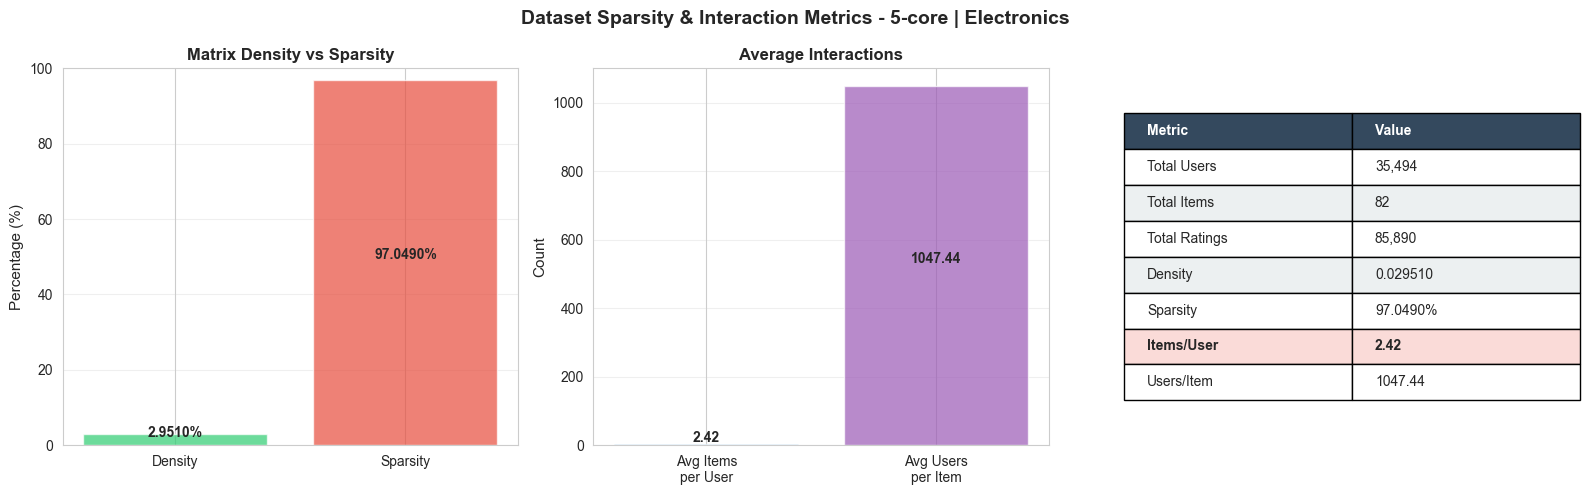

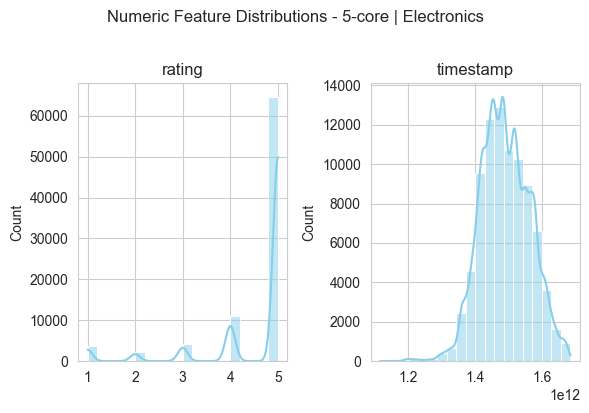

2025-10-10 21:54:26,279 - INFO - [Ratings] 5-core | Electronics | mean=4.53, median=5.00, mode=5.0 | pos=88.3%, neu=4.9%, neg=6.8%


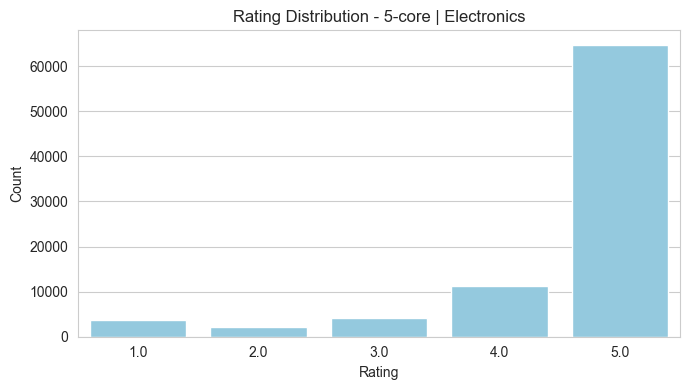

2025-10-10 21:54:26,349 - INFO - [Users] 5-core | Electronics | unique_users=35,494 | avg_ratings_per_user=2.42 | median=2 | max=25


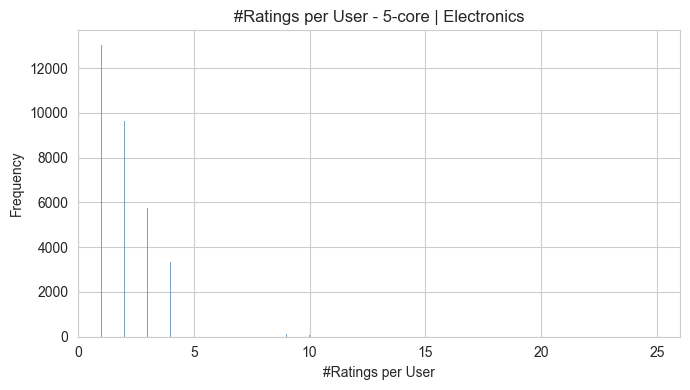

2025-10-10 21:54:26,937 - WARNING - [Skip 5core] Electronics: `bins` must increase monotonically, when an array
2025-10-10 21:54:27,008 - INFO - --- Category: Beauty_and_Personal_Care ---
2025-10-10 21:54:27,008 - WARNING - [Skip 0core] Beauty_and_Personal_Care: Invalid core '0core'. Must be one of: ['5core']
2025-10-10 21:54:27,008 - INFO - [Loader] core=5core, category=Beauty_and_Personal_Care, splits=['train']
2025-10-10 21:54:27,009 - INFO - [Loader] Reading: Beauty_and_Personal_Care.5core.train.big.parquet
2025-10-10 21:54:27,011 - INFO - [Loader] Loaded train: rows=7718, cols=4
2025-10-10 21:54:27,011 - INFO - [Loader] Done core=5core, category=Beauty_and_Personal_Care | rows=7718, cols=4 | users=6613 | items=8 | density=0.145887
2025-10-10 21:54:27,012 - INFO - === Full EDA for 5-core dataset===
2025-10-10 21:54:27,012 - INFO - [Basic] 5-core | Beauty_and_Personal_Care | users=6,613 | items=8 | ratings=7,718
2025-10-10 21:54:27,012 - INFO - [Basic] 5-core | Beauty_and_Personal_C

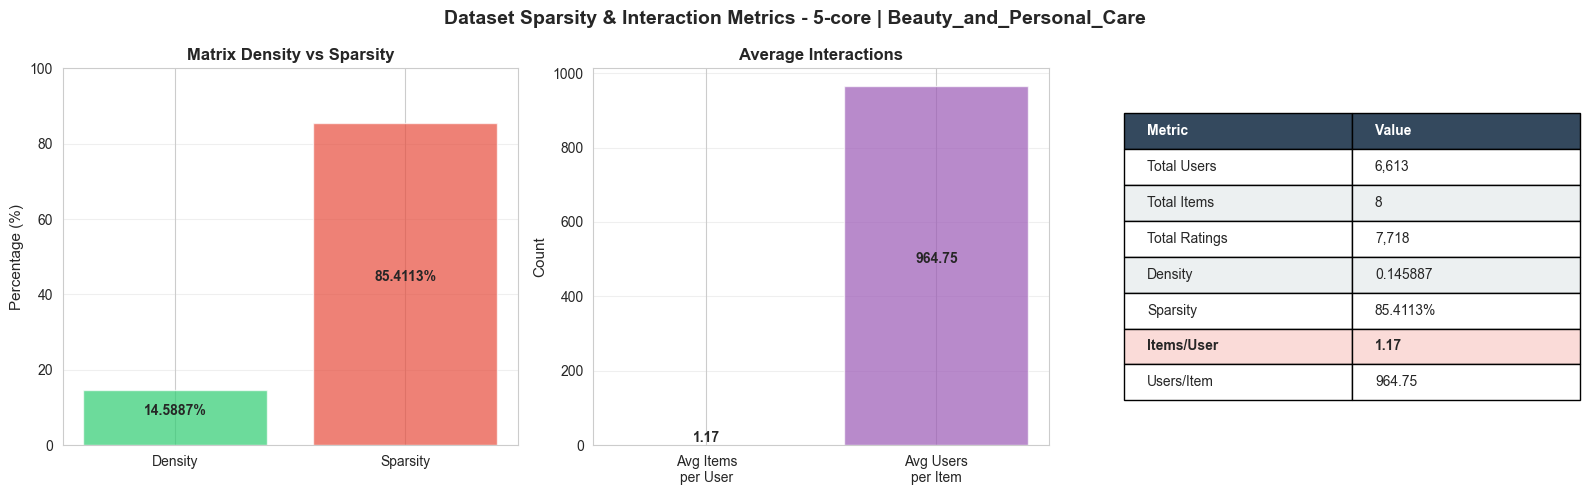

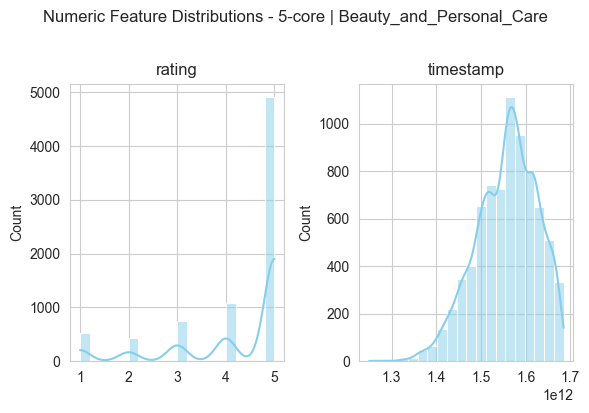

2025-10-10 21:54:27,249 - INFO - [Ratings] 5-core | Beauty_and_Personal_Care | mean=4.22, median=5.00, mode=5.0 | pos=77.8%, neu=9.8%, neg=12.4%


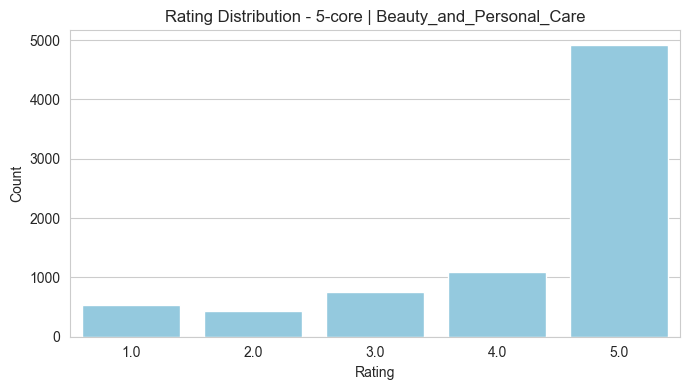

2025-10-10 21:54:27,305 - INFO - [Users] 5-core | Beauty_and_Personal_Care | unique_users=6,613 | avg_ratings_per_user=1.17 | median=1 | max=5


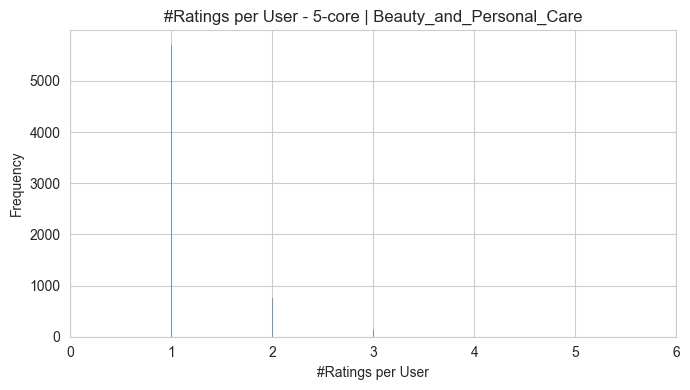

2025-10-10 21:54:27,809 - WARNING - [Skip 5core] Beauty_and_Personal_Care: `bins` must increase monotonically, when an array
2025-10-10 21:54:27,943 - INFO - --- Category: Sports_and_Outdoors ---
2025-10-10 21:54:27,943 - WARNING - [Skip 0core] Sports_and_Outdoors: Invalid core '0core'. Must be one of: ['5core']
2025-10-10 21:54:27,944 - INFO - [Loader] core=5core, category=Sports_and_Outdoors, splits=['train']
2025-10-10 21:54:27,944 - INFO - [Loader] Reading: Sports_and_Outdoors.5core.train.big.parquet
2025-10-10 21:54:27,946 - INFO - [Loader] Loaded train: rows=3250, cols=4
2025-10-10 21:54:27,946 - INFO - [Loader] Done core=5core, category=Sports_and_Outdoors | rows=3250, cols=4 | users=3079 | items=3 | density=0.351846
2025-10-10 21:54:27,947 - INFO - === Full EDA for 5-core dataset===
2025-10-10 21:54:27,947 - INFO - [Basic] 5-core | Sports_and_Outdoors | users=3,079 | items=3 | ratings=3,250
2025-10-10 21:54:27,947 - INFO - [Basic] 5-core | Sports_and_Outdoors | density=0.351846

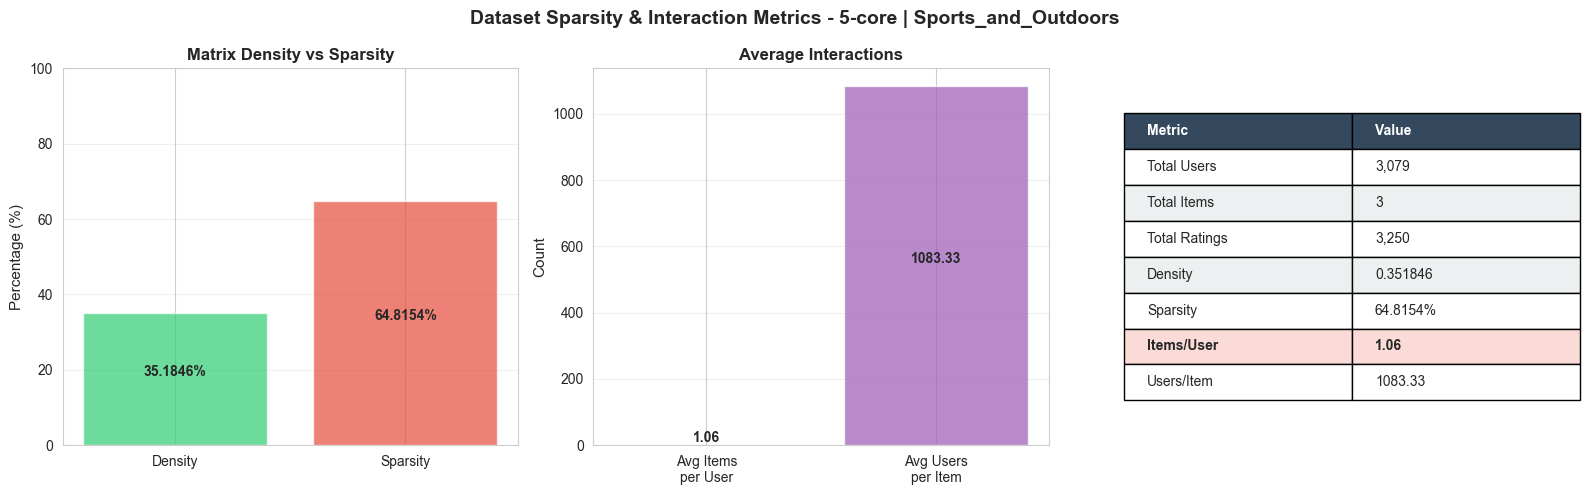

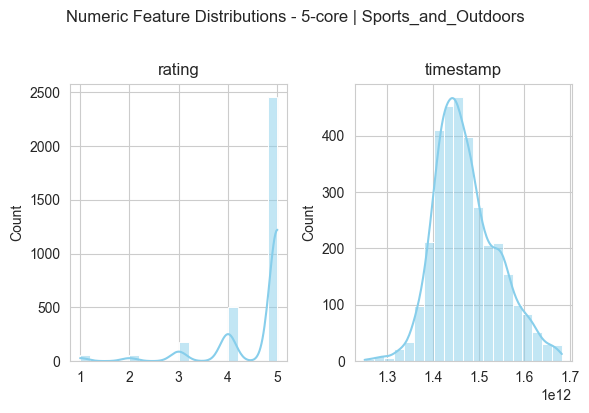

2025-10-10 21:54:28,231 - INFO - [Ratings] 5-core | Sports_and_Outdoors | mean=4.62, median=5.00, mode=5.0 | pos=91.1%, neu=5.4%, neg=3.4%


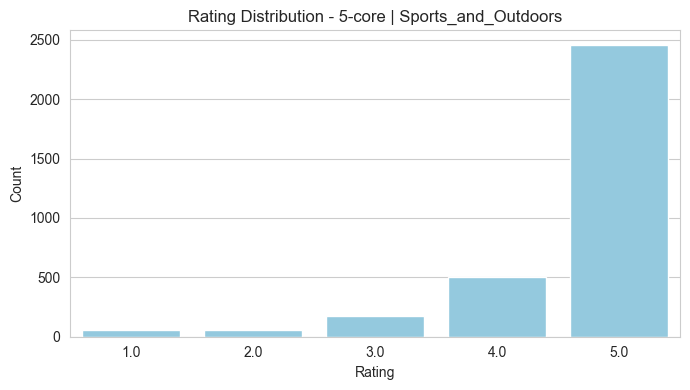

2025-10-10 21:54:28,287 - INFO - [Users] 5-core | Sports_and_Outdoors | unique_users=3,079 | avg_ratings_per_user=1.06 | median=1 | max=3


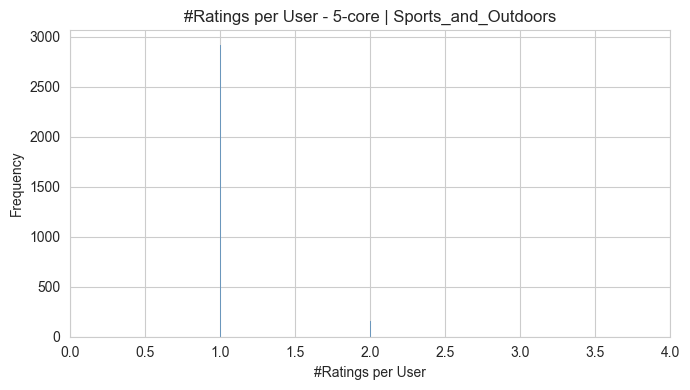

2025-10-10 21:54:28,783 - WARNING - [Skip 5core] Sports_and_Outdoors: `bins` must increase monotonically, when an array


In [12]:
run_for_categories(categories=VALID_CATEGORIES)